In [76]:
from helpers import *
import numpy as np
import pandas as pd
from implementations import *

In [77]:
## Use pickle instead of csv, much faster, please comment out below 
data_path = '../data/dataset_to_release'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path)

# Data cleaning

### Getting an idea of the data 
Find really bad columns and drop them

In [78]:
print("X train", x_train.shape)
print("X test", x_test.shape)

X train (328135, 321)
X test (109379, 321)


Text(0, 0.5, '# of columns')

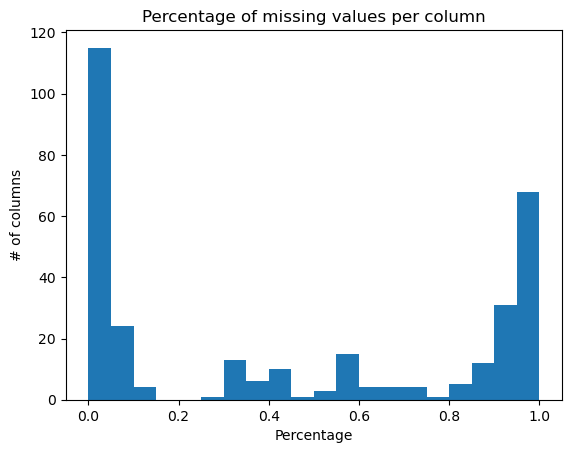

In [79]:
## Find how many values are completely empty in column
def percentageFilled(data):
    return np.isnan(data).sum()/ len(data)

percentage_missing = np.apply_along_axis(percentageFilled, 0, x_train)

import matplotlib.pyplot as plt
plt.hist(percentage_missing, bins=20)
plt.title("Percentage of missing values per column")
plt.xlabel("Percentage")
plt.ylabel("# of columns")

### Data cleaning 

1. remove columns where 80% of the values are missing
2. replace the missing values of X with the mean of the column
3. standardize the data
4. add column of 1 at the beginning  

# **Make sure you do the same for x_test**

In [95]:
## Process data 
## 1. drop the columns with more than 80% missing values
def filter_columns_by_threshold(data, threshold): 
    """ 
    filter out data where the column has less than threshold percentage of data
    returns: 
        indicies of columns to keep
        data with those columns
    """
    percentage_missing = np.apply_along_axis(percentageFilled, 0, data)
    percentage_filled_index = np.array([1 if x>= threshold else 0 for x in percentage_missing])
    keep_indicies = percentage_filled_index * (np.arange(0, data.shape[1], 1)) 
    keep_indicies = keep_indicies[keep_indicies != 0]
    return keep_indicies, data[:, keep_indicies]

keep_indicies, x_train_2 = filter_columns_by_threshold(x_train, 0.8)
print("X train", x_train_2.shape)
print("keep_indicies", keep_indicies)

X train (328135, 116)
keep_indicies [ 11  14  22  41  49  55  64  74 107 108 109 110 111 112 113 114 115 116
 117 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 224 225 226]


In [96]:
def filter_columns_by_indicies(data, keep_indicies):
    """
    used to process test data 
    only keep the columns that are in the indicies 
    """
    return data[:, keep_indicies]
x_test_2 = filter_columns_by_indicies(x_test, keep_indicies)
print("X test", x_test_2.shape)   

X test (109379, 116)


In [97]:
## 2. Replace the missing values with the mean of the column, add columns 
def standardize(x):
   """Standardize the original data set."""
   mean_x = np.mean(x, axis=0)
   x = x - mean_x
   std_x = np.std(x, axis=0)
   x = x / std_x
   return x, mean_x, std_x

def process_data(x):
   col_means = np.nanmean(x, axis=0)
   inds = np.where(np.isnan(x))
   x[inds] = np.take(col_means, inds[1])  # replace columns with values NaN with the mean of that column
   # x = (x - np.mean(x)) / np.std(x)  # standarize the data 
   ## ?? I feel like standardizing by column shouldn't be done like above 
   x, _, _ = standardize(x)[0]
   x = np.c_[np.ones(len(x)), x]  # add the column of ones
   return x

x_train_2 = process_data(x_train_2)
x_test_2 = process_data(x_test_2)

# Logistic regression *without* regularization

In [83]:
initial_w = np.ones(x_train_2.shape[1], dtype=np.float128) 
max_iters = 100
gamma = 0.5

In [84]:
## Here the logistic regression is from implementations.py
## takes around 20 mins to run for 100 iters
w, loss = logistic_regression(y_train, x_train_2, initial_w, max_iters, gamma)

/Users/gladys/Desktop/project1/grading_tests/implementations.py:136: RuntimeWarning: overflow encountered in exp
  return np.where(t < 0, np.exp(t)/(1.0 +np.exp(t)) , 1.0 / (1.0 + np.exp(-t)))  ##


In [85]:
print("loss is ", loss)
print("w is ", w)

loss is  -17.063451261087802526
w is  [ -40.49858107   11.52468301   11.2950626    11.52468301   11.35414853
   -7.149214     11.27270861   11.17166533   11.36538859   11.30719899
   10.89412438   11.28618573  -77.27044744  -82.38225103    6.81309916
    6.81880601    3.38029462   11.03047825   11.21425877   11.36147759
    9.22743525   10.69947381   11.10218047    7.4358176    11.33800348
   11.43367513    9.94597489   11.10096937   11.39816474   11.27106044
   11.03477041    9.76187059   10.88130952   11.3187678    11.02371489
   11.19037676   11.17488517   10.48028575   10.44921499   11.10288205
   10.47403104   11.31278241   11.37861363 -137.16841014   11.26750041
  -10.14109889   11.30549497   -9.36257126   -7.09534774   -1.00031867
 -226.23733091   10.38996353   10.01257647   10.32846288   10.15025258
   11.27120294   11.29795847   11.27533955   10.8749457    11.2390059
   11.415302     11.27474667   11.09288285   11.28682478   11.35160726
   11.21080097   10.67813355   11.051286

### Trying to predict x_test

In [103]:
def prediction_labels(weights, data): ## isn't this for linear regression only ? Don't we need the sigmoid?
   """Generates class predictions given weights, and a test data matrix."""
   y_pred = sigmoid(np.dot(data, weights))
   display(y_pred)
   y_pred[np.where(y_pred >=0.5)] = 1
   y_pred[np.where(y_pred < 0.5)] = -1
   return y_pred

y_pred = prediction_labels(w, x_train_2)
temp = y_pred[y_pred != -1]
print("temp", temp.shape)

/Users/gladys/Desktop/project1/grading_tests/implementations.py:136: RuntimeWarning: overflow encountered in exp
  return np.where(t < 0, np.exp(t)/(1.0 +np.exp(t)) , 1.0 / (1.0 + np.exp(-t)))  ##


array([7.11427486e-1779, 6.65742862e-1779, 6.31747824e-1779, ...,
       6.06829266e-1779, 6.03190407e-1779, 2.37744356e-1978],
      dtype=float128)

temp (0,)


In [100]:
print("x_train_2", x_train_2.shape, "w shape", w.shape)

x_train_2 (328135, 117) w shape (117,)


### Logistic regression with regularization